# AlexNet_resize

### AlexNet
- 2012년 ILSVRC 우승 모델 / error_rate:17%

1. Architecture
    - 5 Convolution_Layey + 3 Fully_Connected_Layer
    - Local Response Normalization (Batch Normalization와 유사)
    - Overlapping Pooling(X)
    - Dropout(0.5)
    - activation_function = ReLU
    - loss_function = Cross_Entropy
    - optimizer = Adam
2. Dataset
    - Data Augmentation(x)
    - tf.keras.layers.Resizing (Resizing 레이어 추가)

* 약 9894만개의 매개변수

## Mount Google Drive

In [5]:
# Colab 사용시
# from google.colab import drive
# drive.mount('/content/drive')

## Import Library

In [6]:
# Data
import numpy as np
import pandas as pd

# Preprcessing

# Model
import tensorflow as tf
from tensorflow.keras import Sequential, activations
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Evaluation
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Visualizatoin
from PIL import Image
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

# Env
import os

## GPU Setting

In [7]:
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

GPU found


## Hyper parameters

In [8]:
#Colab
DATA_DIR='../data/'
SAVE_DIR='../model/AlexNet_resize/'
LOAD_DIR='../model/AlexNet_resize/'

#Server
DATA_DIR='../data/'
SAVE_DIR='../model/AlexNet_resize/'
LOAD_DIR='../model/AlexNet_resize/'

#Local
# DATA_DIR='C:/Users/is910/Desktop/MNIST/data/'
# SAVE_DIR='C:/Users/is910/Desktop/MNIST/model/AlexNet_resize/'
# LOAD_DIR='C:/Users/is910/Desktop/MNIST/model/AlexNet_resize/'

#Hyper parameter
BATCH_SIZE=128
SHUFFLE_BUFFER_SIZE=100
VERBOSE=1
PATIENCE=3
VALIDATION_SPLIT=0.2
EPOCHS=10

## Load data

In [9]:
raw_mnist = tf.keras.datasets.mnist

In [10]:
(X_train_raw, y_train), (X_test_raw, y_test) = raw_mnist.load_data()

In [11]:
np.info(X_train_raw)

class:  ndarray
shape:  (60000, 28, 28)
strides:  (784, 28, 1)
itemsize:  1
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x20d80fda040
byteorder:  little
byteswap:  False
type: uint8


test 개수

In [13]:
print(X_test_raw.shape)

(10000, 28, 28)


In [14]:
print(y_train.shape)

(60000,)


### Matplotlib Image

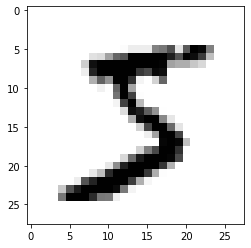

In [15]:
plt.imshow(X_train_raw[0], cmap='gray_r', interpolation='nearest')
plt.show()

### PIL Image

In [16]:
# pil_image = Image.fromarray(X_train_raw[0])
# pil_image.show()

## Preprocessing

### Numpy to Tensor

In [17]:
X_train_tensor = tf.convert_to_tensor(X_train_raw)
X_test_tensor = tf.convert_to_tensor(X_test_raw)

In [18]:
X_train_tensor.shape

TensorShape([60000, 28, 28])

### Reshape Tensor

In [19]:
X_train_reshape_tensor=tf.reshape(X_train_tensor, [60000, 28, 28, -1])
X_test_reshape_tensor=tf.reshape(X_test_tensor, [10000, 28, 28, -1])
#X_train=X_train_reshape_tensor.reshape((60000, 28, 28, -1))

In [20]:
X_train_reshape_tensor.shape

TensorShape([60000, 28, 28, 1])

### Min-Max Scaling

In [21]:
X_train_scaled, X_test_scaled = X_train_reshape_tensor/255, X_test_reshape_tensor/255

In [22]:
X_train_scaled.shape

TensorShape([60000, 28, 28, 1])

In [23]:
X_train, X_test = X_train_scaled, X_test_scaled

## Model definition
### AlexNet_resize

In [24]:
def AlexNet():
    # inputs = tf.keras.Input(X_train[0].shape)
    inputs = tf.keras.Input(shape=(28, 28, 1))
    
    # Resizing layer
    resize = tf.keras.layers.Resizing(height=227, width=227, interpolation='bilinear')(inputs)
    
    # first convolution layer
    conv_1 = tf.keras.layers.Conv2D(filters=96, kernel_size=11, strides=1, padding='valid', activation=activations.relu)(resize)
    pool_1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2)(conv_1)
    norm_1 = tf.nn.local_response_normalization(pool_1, depth_radius=5, bias=1, alpha=1, beta=0.5)

    # second convolution layer
    conv_2 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation=activations.relu)(norm_1)
    pool_2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2)(conv_2)
    norm_2 = tf.nn.local_response_normalization(pool_2, depth_radius=5, bias=1, alpha=1, beta=0.5)

    # third convolution layer
    conv_3 = tf.keras.layers.Conv2D(filters=384, kernel_size=3, strides=1, padding='same', activation=activations.relu)(norm_2)

    # fourth convolution layer
    conv_4 = tf.keras.layers.Conv2D(filters=384, kernel_size=3, strides=1, padding='same', activation=activations.relu)(conv_3)

    # fifth convolution layer
    conv_5 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation=activations.relu)(conv_4)
    pool_5 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2)(conv_5)
    norm_5 = tf.nn.local_response_normalization(pool_5, depth_radius=5, bias=1, alpha=1, beta=0.5)

    # fully connected layer
    flatten = tf.keras.layers.Flatten()(norm_5) # 2304
    dense_1 = tf.keras.layers.Dense(units=512, activation=activations.relu)(flatten)
    dropout_1 = tf.keras.layers.Dropout(rate=0.5)(dense_1)
    dense_2 = tf.keras.layers.Dense(units=128, activation=activations.relu)(dropout_1)
    dropout_2 = tf.keras.layers.Dropout(rate=0.5)(dense_2)
    outputs = tf.keras.layers.Dense(units=10, activation=activations.softmax)(dropout_2)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

## Model Summary

In [25]:
model = AlexNet()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 resizing (Resizing)         (None, 227, 227, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 217, 217, 96)      11712     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 108, 108, 96)     0         
 )                                                               
                                                                 
 tf.nn.local_response_normal  (None, 108, 108, 96)     0         
 ization (TFOpLambda)                                            
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 108, 256)     221440

## Model Compile

In [22]:
#early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=VERBOSE, patience=PATIENCE, restore_best_weights=True)
mcp = ModelCheckpoint(SAVE_DIR+'best-model.h5', monitor='val_accuracy', mode='max', verbose=VERBOSE, save_best_only=True)

#compile
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Train Model

In [23]:
history = model.fit(X_train, y_train, epochs=EPOCHS, callbacks=[es, mcp], batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT)

Epoch 1/10
750/750 [==============================] - ETA: 0s - loss: 0.3493 - accuracy: 0.8935
Epoch 1: val_accuracy improved from -inf to 0.97967, saving model to ../model/AlexNet_resize\best-model.h5
750/750 [==============================] - 573s 749ms/step - loss: 0.3493 - accuracy: 0.8935 - val_loss: 0.0714 - val_accuracy: 0.9797
Epoch 2/10
750/750 [==============================] - ETA: 0s - loss: 0.1161 - accuracy: 0.9689
Epoch 2: val_accuracy improved from 0.97967 to 0.98308, saving model to ../model/AlexNet_resize\best-model.h5
750/750 [==============================] - 560s 747ms/step - loss: 0.1161 - accuracy: 0.9689 - val_loss: 0.0554 - val_accuracy: 0.9831
Epoch 3/10
750/750 [==============================] - ETA: 0s - loss: 0.0834 - accuracy: 0.9766
Epoch 3: val_accuracy did not improve from 0.98308
750/750 [==============================] - 559s 745ms/step - loss: 0.0834 - accuracy: 0.9766 - val_loss: 0.0692 - val_accuracy: 0.9808
Epoch 4/10
750/750 [===================

## Test Model

In [24]:
loaded_model = load_model(SAVE_DIR+'best-model.h5')
loss, acc = loaded_model.evaluate(X_test, y_test)

print('Test loss:', loss)
print('Test accuracy:', acc)

313/313 [==============================] - 37s 118ms/step - loss: 0.0372 - accuracy: 0.9895
Test loss: 0.03718752786517143
Test accuracy: 0.9894999861717224


## Save Model

In [25]:
model_name = 'trained-model.h5'

# Save model and weights
model_path = os.path.join(SAVE_DIR, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at ../model/AlexNet_resize/trained-model.h5 


## Evaluation

### Loss / Accuracy

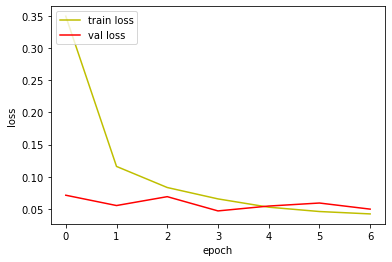

In [26]:
fig, loss_ax = plt.subplots()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper left')
plt.show()

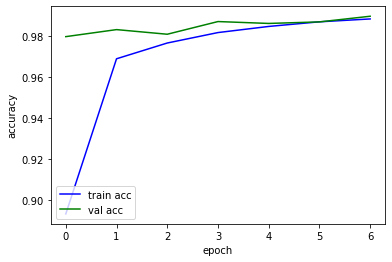

In [27]:
fig, acc_ax = plt.subplots()

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')

acc_ax.set_xlabel('epoch')
acc_ax.set_ylabel('accuracy')

acc_ax.legend(loc='lower left')

plt.show()

In [28]:
# fig, loss_ax = plt.subplots()
# acc_ax = loss_ax.twinx()

# loss_ax.plot(history.history['loss'], 'y', label='train loss')
# loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

# acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
# acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')

# loss_ax.set_xlabel('epoch')
# loss_ax.set_ylabel('loss')
# acc_ax.set_ylabel('accuracy')

# loss_ax.legend(loc='upper left')
# acc_ax.legend(loc='lower left')

# plt.show()


### Confusion matrix

In [29]:
y_pred = loaded_model.predict(X_test)
y_pred = y_pred.argmax(axis=-1)
print(y_pred)

313/313 [==============================] - 36s 115ms/step
[7 2 1 ... 4 5 6]


[[ 973    1    1    1    0    0    3    0    0    1]
 [   0 1132    1    0    0    0    0    1    1    0]
 [   2    1 1016    0    0    0    1    7    5    0]
 [   0    0    1 1004    0    3    0    1    1    0]
 [   0    0    2    0  972    0    5    0    1    2]
 [   1    0    0    9    0  875    4    0    3    0]
 [   3    4    0    0    1    2  946    0    2    0]
 [   0    0    4    2    0    0    0 1021    0    1]
 [   2    0    2    1    0    0    1    1  961    6]
 [   1    1    0    2    5    2    1    2    0  995]]


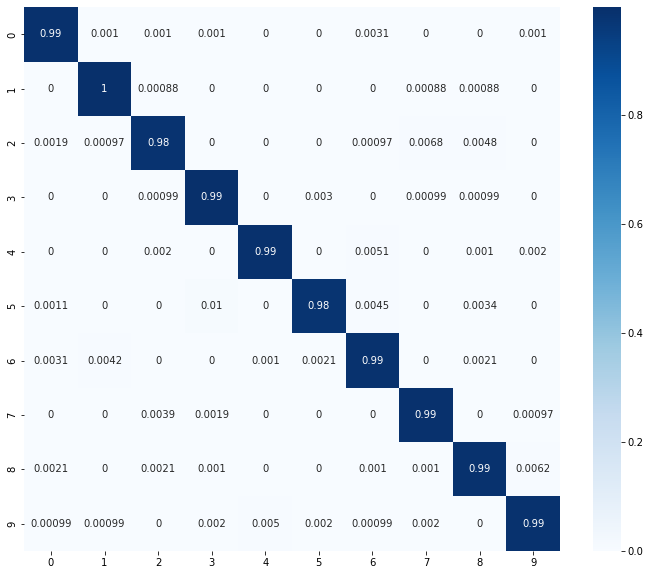

In [30]:
# constant for classes
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

# Build confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)
df_cm = pd.DataFrame(cf_matrix/cf_matrix.sum(axis=1).reshape(10, 1), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,10))
sn.heatmap(df_cm, annot=True, cmap='Blues')
plt.savefig(SAVE_DIR + 'output.png')

### precision, recall, f1 score

In [31]:
acc_score = accuracy_score(y_test, y_pred)
prec_score = precision_score(y_test, y_pred, average='macro')
re_score = recall_score(y_test, y_pred, average='macro')
f1_score_s = f1_score(y_test, y_pred, average='macro')
print("accuracy_score: ", acc_score)
print("precision_score: ", prec_score)
print("recall_score: ", re_score)
print("f1_score: ", f1_score_s)

accuracy_score:  0.9895
precision_score:  0.9894664026426048
recall_score:  0.9892970324642343
f1_score:  0.9893740156640314


## Load Model

In [32]:
model_name='trained-model.h5'
model_path=os.path.join(LOAD_DIR, model_name)
model=load_model(model_path)

## Predict

In [33]:
print(X_train.shape, X_train[0].shape, sep='\n')

(60000, 28, 28, 1)
(28, 28, 1)


In [34]:
def predict_mnist(tensor, model):
    sample=tf.reshape(tensor, [-1, 28, 28])
    result_prob=model.predict(sample, verbose=0)
    result=np.argmax(result_prob)
    print(result)

5 클래스에 대한 예측

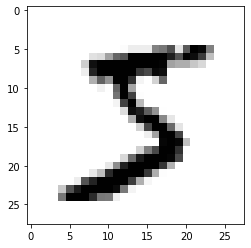

In [35]:
plt.imshow(X_train[0], cmap='gray_r', interpolation='nearest')
plt.show()

In [36]:
predict_mnist(X_train[0], model)

5


 0 클래스에 대한 예측

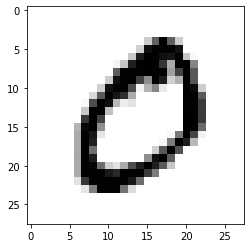

In [37]:
plt.imshow(X_train[1], cmap='gray_r', interpolation='nearest')
plt.show()

In [38]:
predict_mnist(X_train[1], model)

0
